In [45]:
import pandas as pd
import pickle
import requests
import numpy as np
import sys
import matplotlib.pyplot as plt
import seaborn as sns
from collections import Counter
import random
from scipy.spatial.distance import cosine
from sklearn.model_selection import train_test_split
from sklearn.svm import SVC
from sklearn.preprocessing import LabelEncoder, OneHotEncoder
from sklearn.metrics import accuracy_score
from sklearn.ensemble import RandomForestClassifier
from keras.models import Sequential, Model
from keras.layers import Dense, Activation, Concatenate, Input, concatenate, Dropout
from keras.optimizers import Adagrad
from keras import regularizers
from numpy.linalg import svd
from sklearn.decomposition import PCA

In [2]:
perturbagen_class = pickle.load(open("../data/all_perturbagen_class.pkl", "rb"))
perturbagens = list(perturbagen_class.keys())

In [3]:
df = pd.read_csv("../data/full_geneexp_phase2_1004.csv")
def getcellline(x):
    cellline = x.split("_")[1]
    return cellline
df['celline'] = df['signature'].apply(getcellline)

In [4]:
df["atc_level_one"] = [val[0] for val in list(df["atc"])]
imp_columns = ['target', 'atc', 'celline', 'atc_level_one']+list(df.columns[7:985])
df = df[imp_columns]

In [5]:
df.head()

,target,atc,celline,atc_level_one,780,7849,6193,23,9552,387,...,54681,11000,6915,6253,7264,5467,2767,23038,57048,79716
0,BRD-K70330367,N04BB01,YAPC,N,-1.153825,-0.050292,-0.517787,0.244794,-0.399110,0.317308,...,0.440725,0.115513,-0.282635,0.666874,-0.319930,-0.131123,-0.213662,-1.007887,-0.182830,0.524592
1,BRD-K70330367,N04BB01,YAPC,N,-0.150379,0.557618,-0.106715,-0.680913,-0.356638,0.821385,...,-0.017656,2.434079,-0.580103,-0.610206,0.188383,-0.309202,0.056737,-0.003205,-0.434692,-0.177766
2,BRD-K70330367,N04BB01,HA1E,N,0.038450,0.620755,-0.324466,0.136990,0.141210,-0.112033,...,0.224989,0.076725,-0.925917,0.711872,-0.341481,0.437485,-0.052817,-0.376699,-0.047295,-0.215700
3,BRD-K70330367,N04BB01,PC3,N,2.363550,-0.061650,0.691550,0.524950,-0.593000,0.109150,...,0.212650,0.114100,-0.307550,-1.156950,0.508250,-0.230200,-0.314000,-1.208450,-0.630500,-0.447650
4,BRD-K70330367,N04BB01,PC3,N,-0.512800,-0.442350,0.697400,0.108150,-0.552350,0.938150,...,0.358500,-0.641800,-0.603150,-0.792450,0.384800,-0.458000,-0.074800,-0.196750,-0.669750,0.074850


In [6]:
atc_level_vals = np.unique(df.atc_level_one)
cell_lines = [k for k,_ in Counter(df.celline).most_common(7)]

### Cleaning

In [9]:
gene_exp = df[df.columns[4:]]

In [11]:
gene_exp.describe()

,780,7849,6193,23,9552,387,10921,10285,533,6194,...,54681,11000,6915,6253,7264,5467,2767,23038,57048,79716
count,49373.000000,49373.000000,49373.000000,49373.000000,49373.000000,49373.000000,49373.000000,49373.000000,49373.000000,49373.000000,...,49373.000000,49373.000000,49373.000000,49373.000000,49373.000000,49373.000000,49373.000000,49373.000000,49373.000000,49373.000000
mean,0.185011,0.115883,-0.155814,0.168172,0.067040,-0.097537,-0.081883,0.149432,0.039462,-0.150767,...,0.150794,0.279158,0.317956,0.000784,-0.156479,0.299958,0.053321,0.145513,0.100481,0.193440
std,1.204265,1.099367,1.113693,1.137504,1.244738,1.174598,1.228238,1.525019,1.342016,0.896515,...,1.390587,1.319928,1.325199,1.084145,0.970549,1.384550,0.951270,1.371748,1.246402,1.193407
min,-10.000000,-10.000001,-10.000000,-6.017900,-10.000000,-10.000000,-10.000001,-10.000000,-10.000000,-10.000000,...,-10.000000,-9.833800,-9.151626,-9.491443,-10.000000,-4.028850,-10.000000,-10.000000,-10.000000,-10.000000
25%,-0.432395,-0.468567,-0.569700,-0.476989,-0.510112,-0.561984,-0.474747,-0.480400,-0.550579,-0.419550,...,-0.412831,-0.434866,-0.439467,-0.573297,-0.560958,-0.384525,-0.438466,-0.483000,-0.439492,-0.420476
50%,0.030744,-0.007279,-0.031264,-0.024326,-0.053420,0.000513,0.029120,-0.040232,-0.059355,0.000000,...,0.076850,0.069764,0.051750,-0.042322,-0.036715,0.004532,0.039757,0.024803,0.045689,0.058340
75%,0.570980,0.497569,0.452995,0.529768,0.457412,0.503270,0.514091,0.406670,0.418660,0.272238,...,0.623342,0.707008,0.692750,0.563050,0.420220,0.475158,0.544400,0.572813,0.569977,0.629965
max,10.000000,10.000000,7.725900,10.000000,9.494100,9.819663,8.676470,10.000001,10.000000,5.504450,...,10.000000,10.000000,10.000000,10.000000,7.671700,10.000000,7.748153,10.000000,10.000000,10.000000


In [15]:
corr_val = gene_exp.corr()

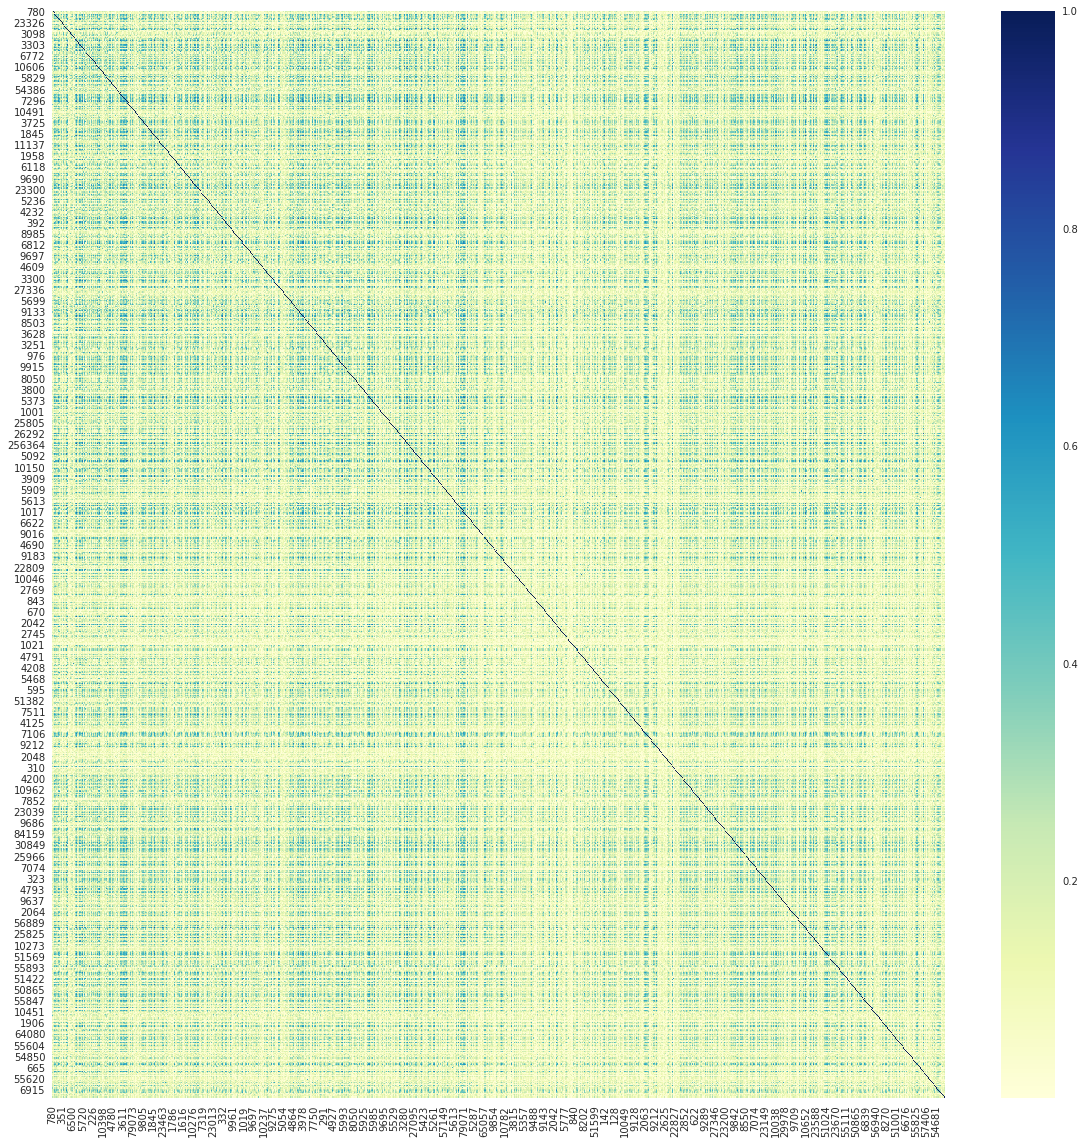

In [37]:
plt.figure(figsize=(20, 20))
sns.heatmap(abs(corr_val), cmap='YlGnBu')

In [38]:
def correlation(dataset, threshold, corr_matrix):
    col_corr = set() # Set of all the names of deleted columns
    for i in range(len(corr_matrix.columns)):
        for j in range(i):
            if (corr_matrix.iloc[i, j] >= threshold) and (corr_matrix.columns[j] not in col_corr):
                colname = corr_matrix.columns[i] # getting the name of column
                col_corr.add(colname)
                if colname in dataset.columns:
                    del dataset[colname] # deleting the column from the dataset

    print(dataset.shape)

In [39]:
correlation(gene_exp, 0.6, abs(corr_val))

(49373, 848)


In [41]:
gene_exp.shape

(49373, 848)

### PCA

In [56]:
pca = PCA(n_components=200)
principalComponents = pca.fit_transform(gene_exp)
principalDf = pd.DataFrame(data = principalComponents)

In [57]:
principalDf['target'] = df['target']
principalDf['atc_level_one'] = df['atc_level_one']
principalDf['celline'] = df['celline']

In [58]:
data = principalDf

### Analysis with lowered data

In [59]:
data = data[data.celline.isin(cell_lines)]

le = LabelEncoder()
le.fit(data['atc_level_one'])

data['atc_level_one'] = le.transform(data['atc_level_one'])

pert_train, pert_test = train_test_split(np.unique(data.target), test_size=0.3)

data_train = data[data.target.isin(pert_train)]
data_test = data[data.target.isin(pert_test)]

data_cell_line_train = {}
for cell_line in cell_lines:
    data_cell_line_train[cell_line] = data_train[data_train.celline==cell_line]
    
data_cell_line_test = {}
for cell_line in cell_lines:
    data_cell_line_test[cell_line] = data_test[data_test.celline==cell_line]

/home/kavya/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  


In [62]:
oe = OneHotEncoder()
oe.fit(le.transform(atc_level_vals).reshape(len(atc_level_vals), 1))
oe.transform(np.array([0]).reshape(-1, 1)).toarray()

/home/kavya/anaconda3/lib/python3.6/site-packages/sklearn/preprocessing/_encoders.py:363: FutureWarning: The handling of integer data will change in version 0.22. Currently, the categories are determined based on the range [0, max(values)], while in the future they will be determined based on the unique values.
If you want the future behaviour and silence this warning, you can specify "categories='auto'".
In case you used a LabelEncoder before this OneHotEncoder to convert the categories to integers, then you can now use the OneHotEncoder directly.
  warnings.warn(msg, FutureWarning)


array([[1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.]])

In [60]:
data.head()

,0,1,2,3,4,5,6,7,8,9,...,193,194,195,196,197,198,199,target,atc_level_one,celline
0,-5.257082,-0.134598,1.757818,-0.725594,1.273415,-1.877676,-0.203924,-1.087020,-0.960852,0.269348,...,-0.784602,0.255551,0.531647,1.060792,0.459342,0.433115,0.400277,BRD-K70330367,9,YAPC
1,-8.665159,-3.950649,0.686245,0.935569,4.511567,-2.608308,-0.672862,1.713215,0.785221,1.509236,...,-1.215660,1.548979,0.150919,0.874471,-0.726853,-0.199695,0.566004,BRD-K70330367,9,YAPC
2,-3.921671,-0.081260,1.371313,-1.158693,1.930126,-1.573228,-0.917163,-0.026915,2.214887,2.658706,...,0.301740,3.372662,-0.742530,-0.995113,-1.507673,0.545141,-0.636758,BRD-K70330367,9,HA1E
3,-7.586705,0.359892,-0.341772,0.849545,2.126741,1.555965,0.668022,2.099231,0.987280,-0.861090,...,2.973878,1.670283,-0.359696,0.588185,-0.251049,-1.500459,-0.332037,BRD-K70330367,9,PC3
4,-10.637969,-4.573388,1.626006,3.706688,3.373440,0.723610,-4.024708,0.232652,-0.994606,0.548662,...,-1.147733,-0.454664,0.222429,-0.680106,0.081275,0.509408,1.242513,BRD-K70330367,9,PC3


In [66]:
class network:
    def __init__(self):
        self.model = Sequential()
        self.model.add(Dense(25, activation='selu', input_dim=200))
        self.model.add(Dense(14, activation='softmax'))
        self.model.compile(optimizer='adagrad',
                      loss='categorical_crossentropy',
                      metrics=['accuracy'])
    def predict(self, X):
        return self.model.predict(X)
    
    def fit(self, X, y):
        self.model.fit(X, y, epochs=20)

network_models = {}

for cell_line in cell_lines:
    X = data_cell_line_train[cell_line][data.columns[:-3]]
    y = oe.transform(np.array(data_cell_line_train[cell_line]['atc_level_one']).reshape(-1, 1)).toarray()
    print(y.shape)
    
    network_models[cell_line] = network()
    network_models[cell_line].fit(X, y) 
    
    y_pred = network_models[cell_line].predict(data_cell_line_test[cell_line][data.columns[:-3]])
    y_true = oe.transform(np.array(data_cell_line_test[cell_line]['atc_level_one']).reshape(-1, 1)).toarray()
    print(accuracy_score(data_cell_line_test[cell_line]['atc_level_one'], np.argmax(y_pred, axis=1)))


pred_cell_line = []
pred = []
for pert in pert_test:
    predictions = []
    all_predictions = []
    for cell_line in cell_lines:
        mini_data = data_cell_line_test[cell_line][data_cell_line_test[cell_line]['target']==pert]
        if mini_data.shape[0]==0:
            continue
        answers = []
        for index in mini_data.index:
            answers+=(list(np.argmax(network_models[cell_line].predict(np.array(
                mini_data[data.columns[:-3]].loc[index]).reshape(1, -1)), axis=1)))
            all_predictions.append(answers[-1])
        predictions.append(Counter(answers).most_common(1)[0][0])
    pred.append(Counter(all_predictions).most_common(1)[0][0])
    pred_cell_line.append(Counter(predictions).most_common(1)[0][0])

y_true = [np.array(data_test[data_test['target']==pert]['atc_level_one'])[0] for pert in pert_test]
accuracy_score(y_true, pred)

(4710, 14)
Epoch 1/20
4710/4710 [==============================] - 0s 84us/step - loss: 2.9115 - acc: 0.2204
Epoch 2/20
4710/4710 [==============================] - 0s 45us/step - loss: 2.2202 - acc: 0.3015
Epoch 3/20
4710/4710 [==============================] - 0s 45us/step - loss: 2.0840 - acc: 0.3318
Epoch 4/20
4710/4710 [==============================] - 0s 48us/step - loss: 2.0093 - acc: 0.3442
Epoch 5/20
4710/4710 [==============================] - 0s 54us/step - loss: 1.9599 - acc: 0.3614
Epoch 6/20
4710/4710 [==============================] - 0s 54us/step - loss: 1.9224 - acc: 0.3684
Epoch 7/20
4710/4710 [==============================] - 0s 45us/step - loss: 1.8950 - acc: 0.3781
Epoch 8/20
4710/4710 [==============================] - 0s 46us/step - loss: 1.8705 - acc: 0.3811
Epoch 9/20
4710/4710 [==============================] - 0s 48us/step - loss: 1.8505 - acc: 0.3887
Epoch 10/20
4710/4710 [==============================] - 0s 45us/step - loss: 1.8332 - acc: 0.3932
Epoch 11

4550/4550 [==============================] - 0s 44us/step - loss: 2.2454 - acc: 0.2769
Epoch 3/20
4550/4550 [==============================] - 0s 46us/step - loss: 2.1163 - acc: 0.3053
Epoch 4/20
4550/4550 [==============================] - 0s 45us/step - loss: 2.0466 - acc: 0.3251
Epoch 5/20
4550/4550 [==============================] - 0s 45us/step - loss: 2.0005 - acc: 0.3341
Epoch 6/20
4550/4550 [==============================] - 0s 46us/step - loss: 1.9657 - acc: 0.3426
Epoch 7/20
4550/4550 [==============================] - 0s 45us/step - loss: 1.9402 - acc: 0.3508
Epoch 8/20
4550/4550 [==============================] - 0s 54us/step - loss: 1.9184 - acc: 0.3582
Epoch 9/20
4550/4550 [==============================] - 0s 45us/step - loss: 1.9005 - acc: 0.3653
Epoch 10/20
4550/4550 [==============================] - 0s 46us/step - loss: 1.8842 - acc: 0.3688
Epoch 11/20
4550/4550 [==============================] - 0s 49us/step - loss: 1.8701 - acc: 0.3708
Epoch 12/20
4550/4550 [======

0.2680851063829787